# Ispezione visiva

In questo notebook analizzeremo visivamente le previsioni del modello in modo da valutare qualitativamente le performance e avere un'intuizione delle forze e debolezze del nostro approccio.

Per questo scopo possiamo riutilizzare gran parte del codice usato per il training con qualche piccola modifica:

 - batch size = 1
 - eliminiamo il random crop iniziale dall'augmentation
 - dataloader su **cpu**
 
Per la visualizzazione invece definiremo alcune utils che fanno al caso nostro.

<div class="alert alert-block alert-info">

Di seguito utilizzeremo solo il **modello costruito con la DiceLoss**, tuttavia il codice è facilmente riusabile per gli altri modelli. L'unica cosa da cambiare è la cartella dove pescare il modelle pre-allenato.
</div>

In [1]:
import sys
from fastai.vision.all import *

sys.path.insert(0, str(Path.cwd().parent))

from utils import write_config, load_config


# data and augmentation params
BS = 1
CROP_SIZE = 512
RESIZE = 224
MAX_LIGHT = 0.1
ZOOM_DELTA = 0.1  # min_zoom = 1 - ZOOM_DELTA; max_zoom = 1 + ZOOM_DELTA
MAX_ROTATION_ANGLE = 15.0

# model params
N_IN, N_OUT = 16, 2

# optimizer params
LOSS_FUNC, LOSS_NAME = DiceLoss(axis=1, smooth=1e-06, reduction='mean', square_in_union=False), 'Dice'

EXP_NAME = "Dice"
log_path = Path().cwd().parent / 'logs' / EXP_NAME  
model_path = log_path.parent.parent / f'models/{EXP_NAME}'

## Dataloader

/home/luca/anaconda3/envs/fx/lib/python3.9/site-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


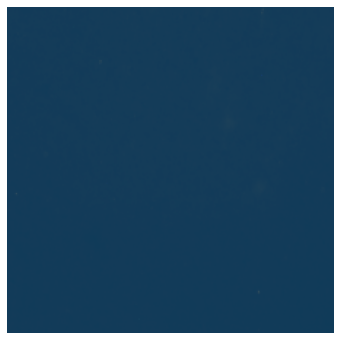

In [2]:
data_path = Path('../fluocells_data/all_images')

# read train/valid/test split dataframe
split_df = pd.read_csv(data_path.parent / 'split_df.csv')
trainval_fnames = [data_path / 'images' / fn
                   for fn in split_df.query("split=='train' or split=='valid'").filename]

def label_func(p):
    return Path(str(p).replace('images', 'masks'))

def is_valid(p):
    return split_df.loc[split_df.filename == p.name, 'split'].values[0] == 'valid'

# augmentation
tfms = [
    IntToFloatTensor(div_mask=255.),  # need masks in [0, 1] format
#     RandomCrop(CROP_SIZE),
    *aug_transforms(
        size=RESIZE, # resize
        max_lighting=MAX_LIGHT, p_lighting=0.5, # variazione luminosità
        min_zoom=1-ZOOM_DELTA, max_zoom=1+ZOOM_DELTA, # zoom
        max_warp=0, # distorsione
        max_rotate=MAX_ROTATION_ANGLE # rotazione
    )
]


# splitter
splitter = FuncSplitter(lambda p: is_valid(p))

# dataloader
dls = SegmentationDataLoaders.from_label_func(
    data_path, fnames=trainval_fnames, label_func=label_func,
    bs=BS,
    splitter=splitter,
    batch_tfms=tfms,
    device='cpu'
)

dls.show_batch(max_n=9, figsize=(6,6))

### Test dataloader

In questo caso siamo interessati a valutare le performance del modello fuori campione.

Per questo motivo aggiungeremo un dataloader che va a pescare direttamente le 28 immagini di test.

Numero immagini di test: 28


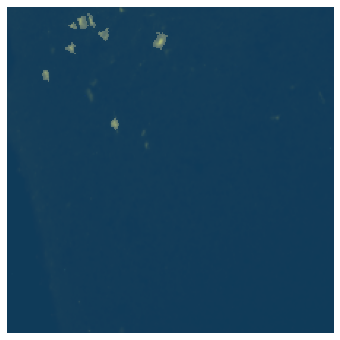

In [3]:
test_fnames = [data_path / 'images' / fn
                   for fn in split_df.query("split=='test'").filename]

print(f"Numero immagini di test: {len(test_fnames)}")
test_dl = dls.test_dl(test_fnames, with_labels=True)
test_dl.show_batch(figsize=(8,6))

## Learner

Anche in questo caso possiamo riutilizzare il codice sfruttato nel training.

Eviteremo tuttavia le callback e le metriche che al momento non ci interessano per l'ispezione visiva.

In [4]:
from blocks import cResUnet

model = cResUnet(N_IN, N_OUT)

learn = Learner(dls, model=model, loss_func=LOSS_FUNC,
                path=log_path , 
                model_dir=model_path,
                )  

print(
    f'Logs save path: {learn.path}\nModel save path: {learn.path / learn.model_dir}')

learn.summary()

Logs save path: /home/luca/PycharmProjects/c-resunet-DLI/logs/Dice
Model save path: /home/luca/PycharmProjects/c-resunet-DLI/models/Dice


cResUnet (Input shape: 1 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     1 x 1 x 224 x 224   
Conv2d                                    4          True      
BatchNorm2d                               2          True      
ELU                                                            
____________________________________________________________________________
                     1 x 16 x 224 x 224  
Conv2d                                    160        True      
BatchNorm2d                               32         True      
ELU                                                            
Conv2d                                    2320       True      
____________________________________________________________________________
                     1 x 16 x 112 x 112  
MaxPool2d                                                      
BatchNorm2d                               32         True      
ELU                                   

## Load model

Una volta definito l'oggetto `Learner`, il modello verrà inizializzato con pesi random come di consueto. 

Per sfruttare i pesi pre-allenati dovremo quindi ripescarli da dove li avevamo salvati con `SaveModelCallback`.

Per fare ciò basta sfruttare il metodo `.load(file)` che andrà a caricare i pesi salvati nel file con estensione *.pth*.

In [5]:
print(f"Loading pesi da: {model_path}")

learn.load(model_path / 'model') # model.pth

Loading pesi da: /home/luca/PycharmProjects/c-resunet-DLI/models/Dice


# Visualizzazione di default

In prima approssimazione è possibile sfruttare il metodo ` show_results` implementato da fastai, passando il **dataloader** costruito per il **test set**.

Come già visto in precedenza, questo mostra il target e la prediction affiancati, con le maschere sovrapposte all'immagine di input.

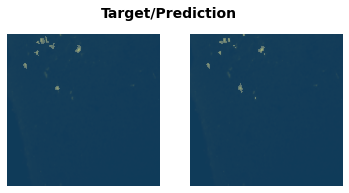

In [6]:
learn.show_results(dl=test_dl)

# Visualizzazioni personalizzate

Per andare un po' più a fondo possiamo invece estrarre manualmente:
 - immagine di input
 - maschera corrispettiva
 - previsione del modello

Una volta recuperati questi elementi, possiamo poi sfruttare librerie di visualizzazione standard (e.g. **matplotlib, plotly**) per ispezionare gli aspetti di maggiore interesse.

## Input/output

A partire dal dataloader di test è possibile estrarre le immagini di input e le relative maschere semplicemente con un ciclo sul dataloader.

In [7]:
for idx, b in enumerate(test_dl):
    img_name = test_dl.items[idx]
    img, mask = b
    break
    
print("Immagine:\t", img_name.stem)
print("Shape immagine:\t", img.shape, img.dtype)
print("Shape maschera:\t", mask.shape, mask.dtype)

Immagine:	 Mar19bS1C5R1_DMr_200x_y
Shape immagine:	 torch.Size([1, 3, 224, 224]) torch.float32
Shape maschera:	 torch.Size([1, 224, 224]) torch.int64


Questi oggetti sono riarrangiati automaticamente dal dataloader per assecondare il formato atteso da pytorch per ogni batch.
In particolare, il formato è **[N_BATCH, C, H, W]**.

Tuttavia matplotlib si aspetta immagini nel formato **[H, W, C]**, per cui dovremo convertire gli oggetti estratti dal dataloader prima di farne il plot.

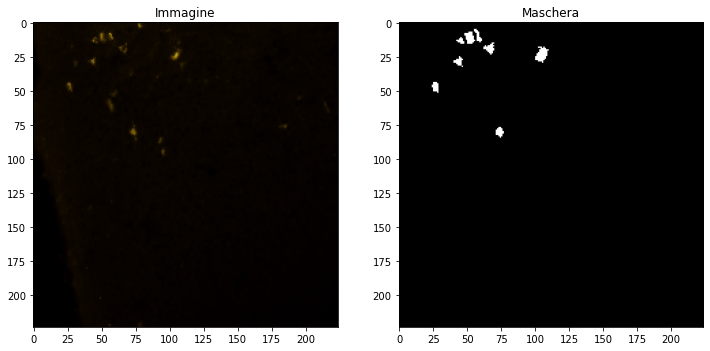

In [8]:
img = img.squeeze().permute(1,2,0) #.to("cpu")
mask = mask.squeeze() #.to("cpu")

fig, axes = plt.subplots(1,2, figsize=(12, 6))
axes[0].imshow(img)
axes[0].set_title('Immagine')
axes[1].imshow(mask, cmap="gray")
axes[1].set_title('Maschera')
plt.show()

## Previsione

Una volta estratti input e output target, possiamo procedere a usare il modello per ottenere una previsione.

Per fare questo basta usare `learn.model(img)`, che restituirà un tensore con shape **[N_BATCH, 2, H, W]**.

Questo output viene comunemente definito **heatmap** e può essere interpretato come una mappa che contiene le probabilità predette dal modello nella classificazione di ogni pixel.
In particolare, 
 - C=0, contiene la probabilità di appartenere alla *classe 0, i.e. "sfondo"* 
 - C=1, contiene la probabilità di appartenere alla *classe 1, i.e. "cellula"*.
 
Essendo interessati al riconoscimento delle cellule possiamo quindi guardare semplicemente il canale **C=1**.

<div class="alert alert-block alert-info">
Anche in questo caso dovremo quindi convertire il tensore prima di poterlo stampare.
</div>

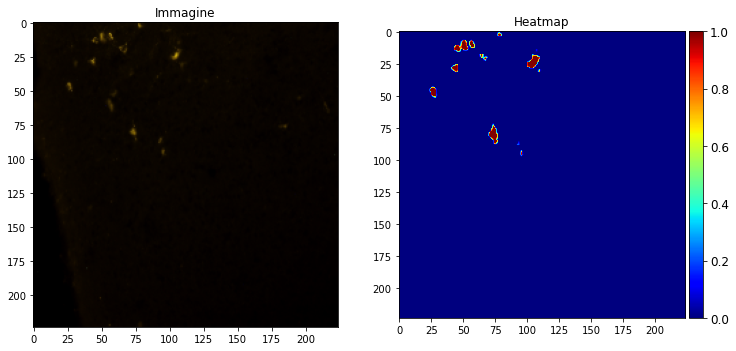

In [9]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


def plot_heatmap(heatmap, ax):
    im = ax.imshow(heatmap, cmap='jet')  
    divider = make_axes_locatable(ax)
    cbar_ax = divider.append_axes("right", size="5%", pad=0.05)

    # get colorbar to set params
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.ax.tick_params(labelsize=12)
    return im

img, mask = b
heatmap = learn.model(img)

# convert to matplotlib format
C=1
img = img.squeeze().permute(1,2,0) #.to("cpu")
heatmap = heatmap.squeeze().permute(1,2,0)[:,:,C].detach() #.to("cpu")

fig, axes = plt.subplots(1,2, figsize=(12, 6))
axes[0].imshow(img)
axes[0].set_title('Immagine')
plot_heatmap(heatmap, axes[1])
axes[1].set_title('Heatmap')
plt.show()

<div class="alert alert-block alert-info">

Nel caso di utilizzo della gpu è consigliabile racchiudere la previsione in un blocco `with` all'interno del quale non vengono tracciati i gradienti (`.no_grad()`), in modo da non riempire la memoria della gpu:
    
```
with torch.no_grad():
    learn.model(img)
```
    
</div>

### Thresholding

La heatmap quindi non contiene una maschera binaria direttamente confrontabile con quella ground-truth.

Per renderla tale, bisognerà quindi prima sottoporla a **thresholding**, i.e. renderla binaria trasformando tutti i pixel con probabilità associata alla classe "cellula" sopra una data soglia in 1 (cellula), e sostituire il valore 0 a tutti gli altri.

Tipicamente la soglia più semplice è da utilizzare è `t=0.5`, che equivale a confrontare le probabilità predette per le 2 classi e attribuire ad ogni pixel la classe con probabilità maggiore.
In pratica, questo equivale a prendere l'`argmax` tra C=0 e C=1.

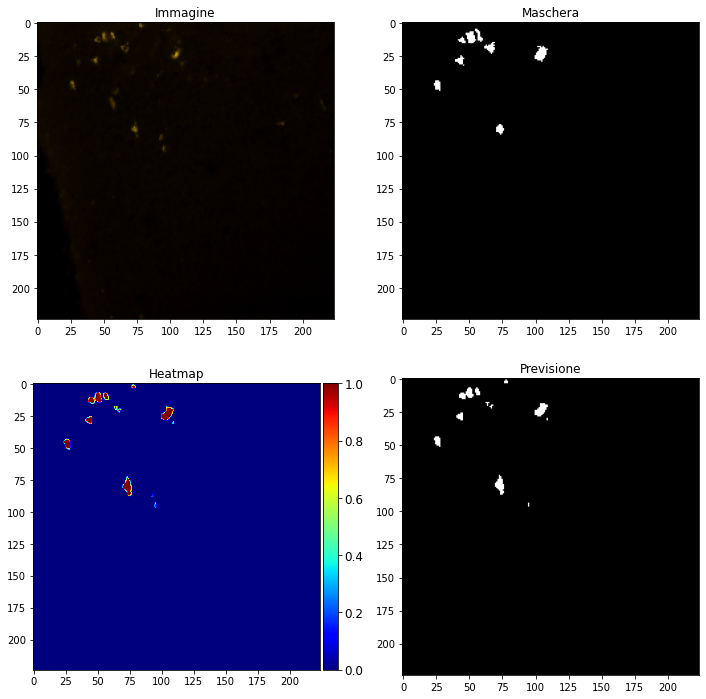

In [10]:
img, mask = b
heatmap = learn.model(img)

# convert to matplotlib format
C=1
img = img.squeeze().permute(1,2,0) #.to("cpu")
mask = mask.squeeze() #.to("cpu")
pred_mask = heatmap.squeeze().permute(1,2,0).argmax(dim=2).squeeze().type(torch.uint8) #.to("cpu")
heatmap = heatmap.squeeze().permute(1,2,0)[:,:,C].detach()

fig, axes = plt.subplots(2,2, figsize=(12, 12))
axes = axes.flatten()
axes[0].imshow(img)
axes[0].set_title('Immagine')
axes[1].imshow(mask, cmap='gray')
axes[1].set_title('Maschera')
plot_heatmap(heatmap, axes[2])
axes[2].set_title('Heatmap')
axes[3].imshow(pred_mask, cmap='gray')
axes[3].set_title('Previsione')
plt.show()

Nell'ultima illustrazione abbiamo quindi tutti gli elementi a cui siamo interessati, partendo dall'immagine e la maschera di input e passando per l'output grezzo del modello e la maschera prevista dopo il thresholding.

A questo punto non ci resta che ripetere questa operazione per tutte le immagini di test e ispezionarle a dovere.

## Plotting utils

In [11]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


def plot_heatmap(heatmap, ax):
    im = ax.imshow(heatmap, cmap='jet')  
    divider = make_axes_locatable(ax)
    cbar_ax = divider.append_axes("right", size="5%", pad=0.05)

    # get colorbar to set params
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.ax.tick_params(labelsize=12)
    return im

def fastai2plt(img, mask, heatmap, pred, device='cpu'):
    C = 1
    img = img.squeeze().permute(1,2,0).to(device)
    mask = mask.squeeze().to(device)
    heatmap = heatmap[:, C, :, :].squeeze().detach().to(device)
    pred = pred.to(device)
    return(img, mask, heatmap, pred)
    
def show_predict(img, mask, heatmap, pred, img_name=None, titles=['Immagine', 'Maschera', 'Heatmap', 'Predizione']):
    img, mask, heatmap, pred = fastai2plt(img, mask, heatmap, pred)
    
    fig, axes = plt.subplots(2, 2, figsize=(16,16))
    fig.suptitle(img_name)
    
    axes = axes.flatten()
    
    axes[0].imshow(img)
    axes[1].imshow(mask, cmap='gray')
    plot_heatmap(heatmap, axes[2])
    axes[3].imshow(pred_mask, cmap='gray')
    
    for ax, title in zip(axes.flatten(), titles):
        ax.set_title(title)
    
    plt.show()

## Prediction utils

In [12]:
def make_prediction(batch):
    img, mask = batch
    with torch.no_grad():
        heatmap = learn.model(img)
    # binarization
    pred_mask = heatmap.argmax(dim=1).squeeze().type(torch.uint8)
    
    return img, mask, heatmap, pred_mask

  0%|          | 0/10 [00:00<?, ?it/s]

/home/luca/anaconda3/envs/fx/lib/python3.9/site-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


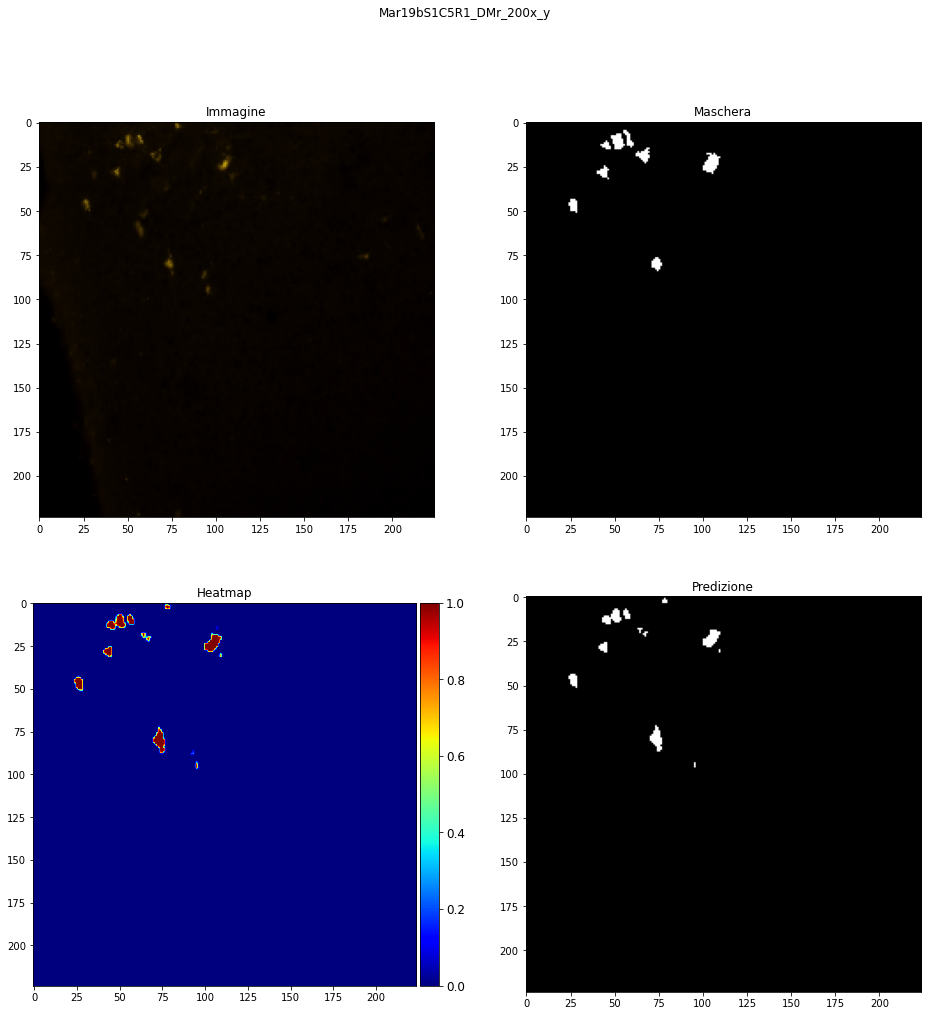

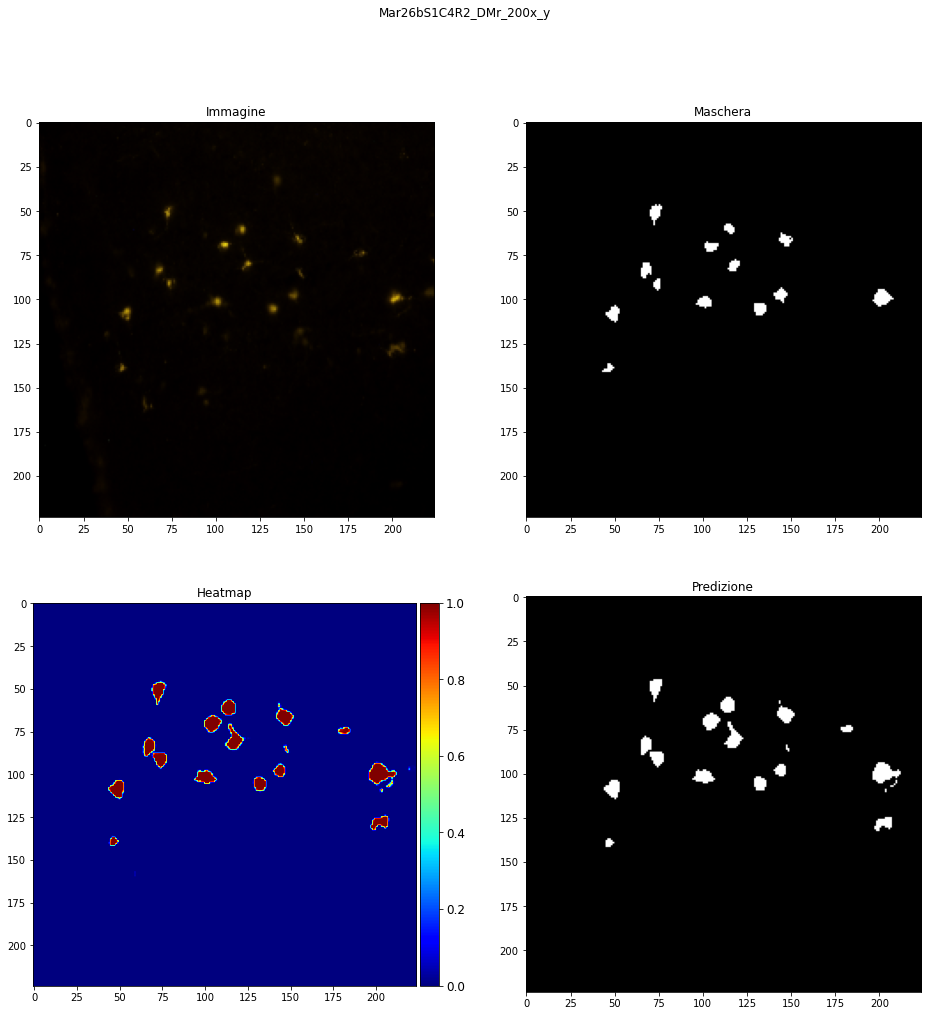

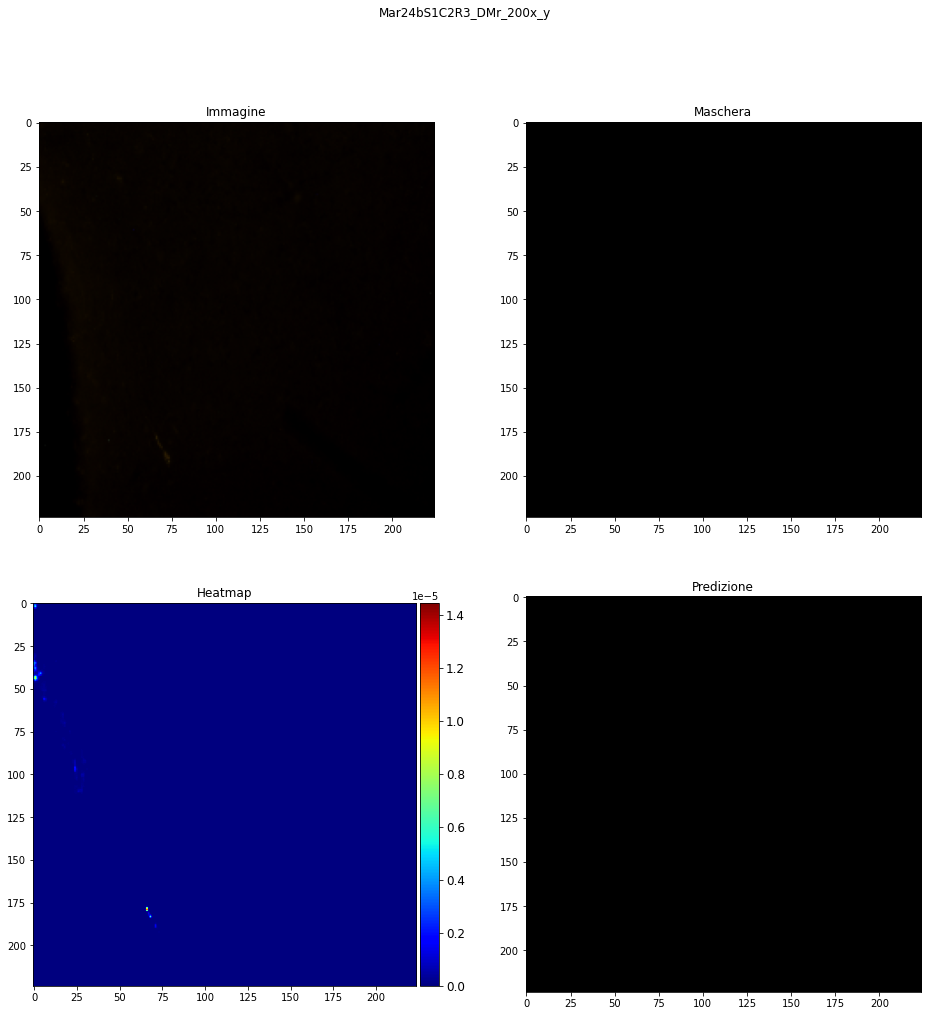

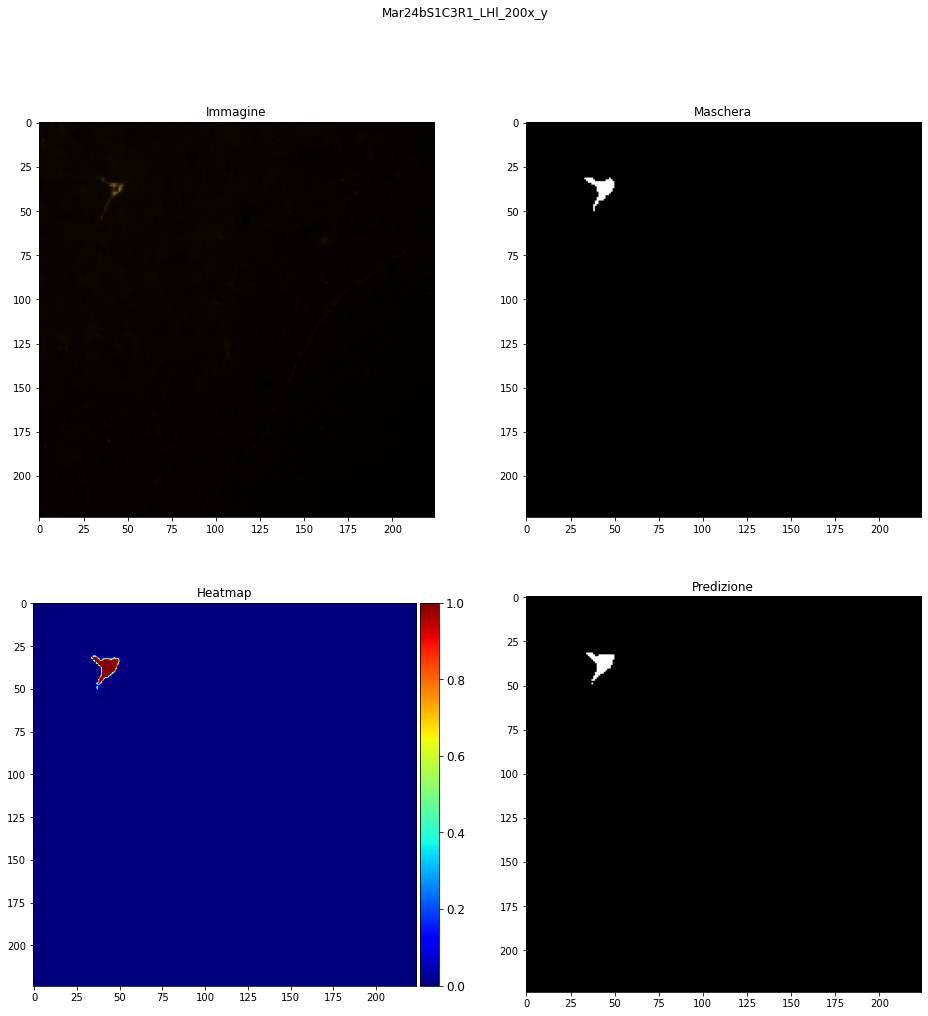

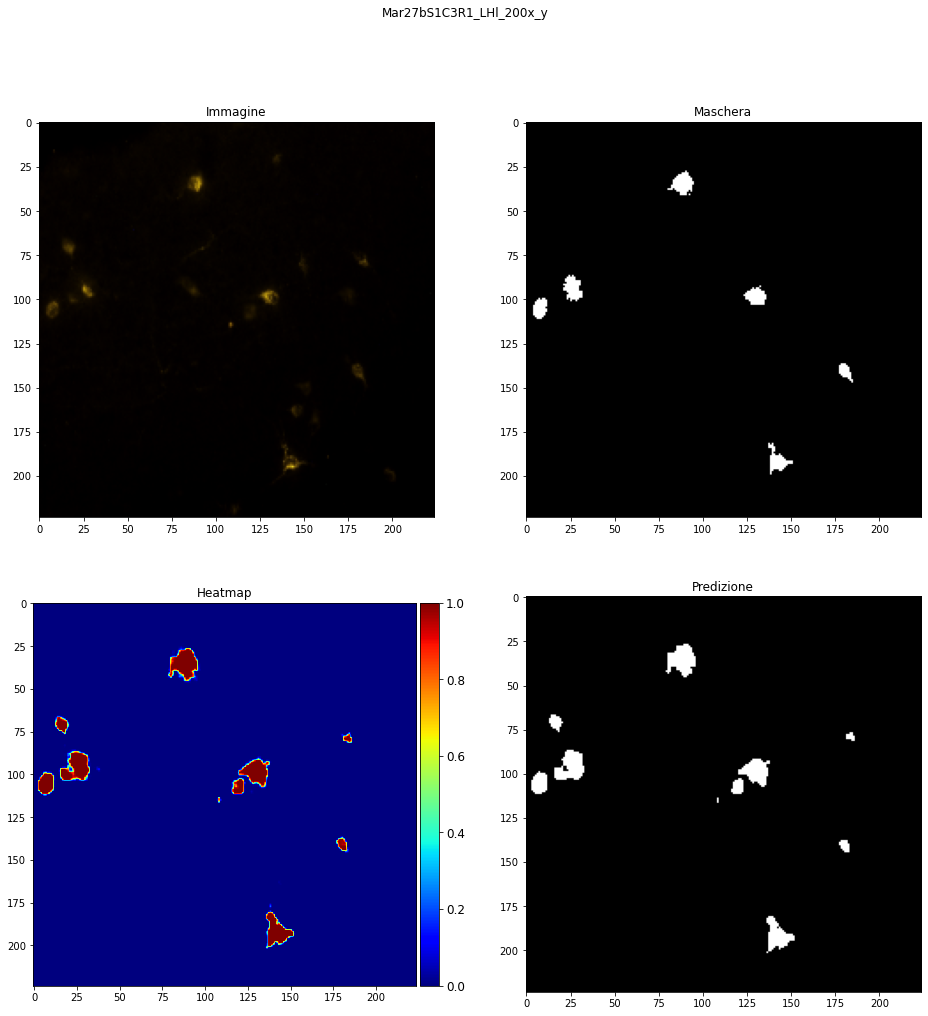

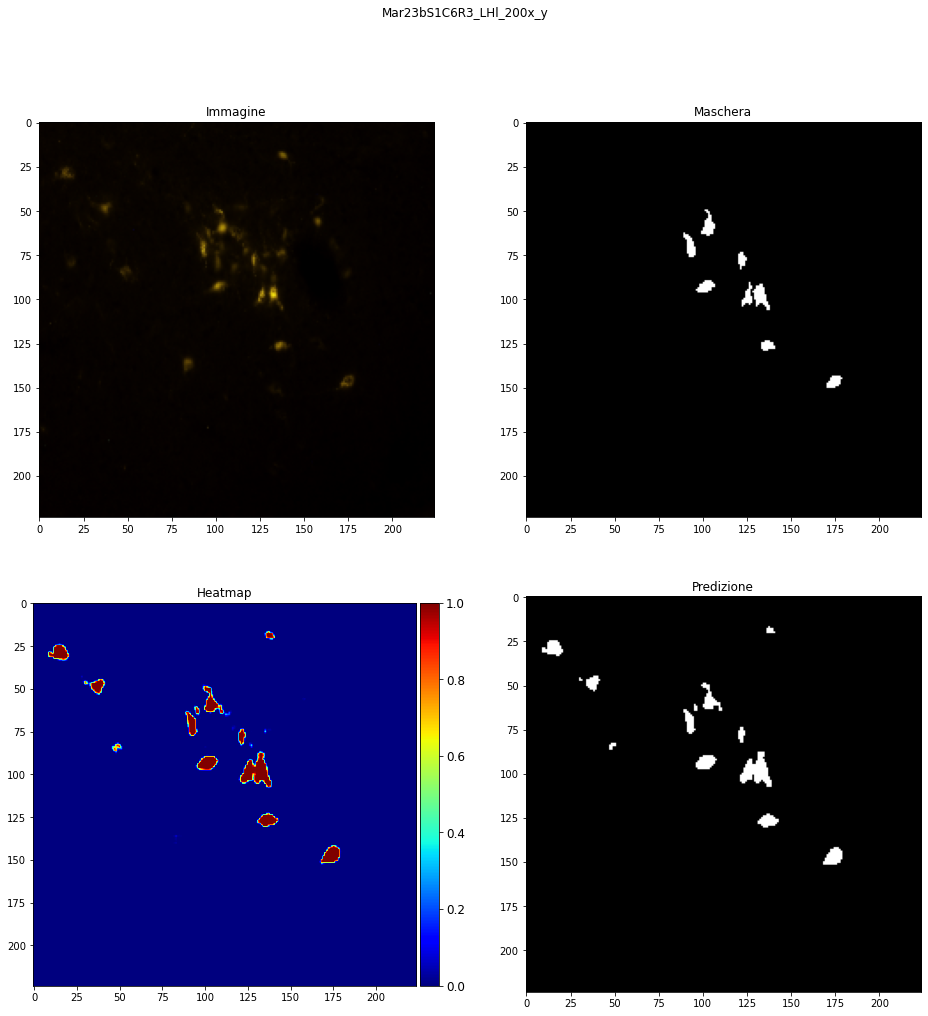

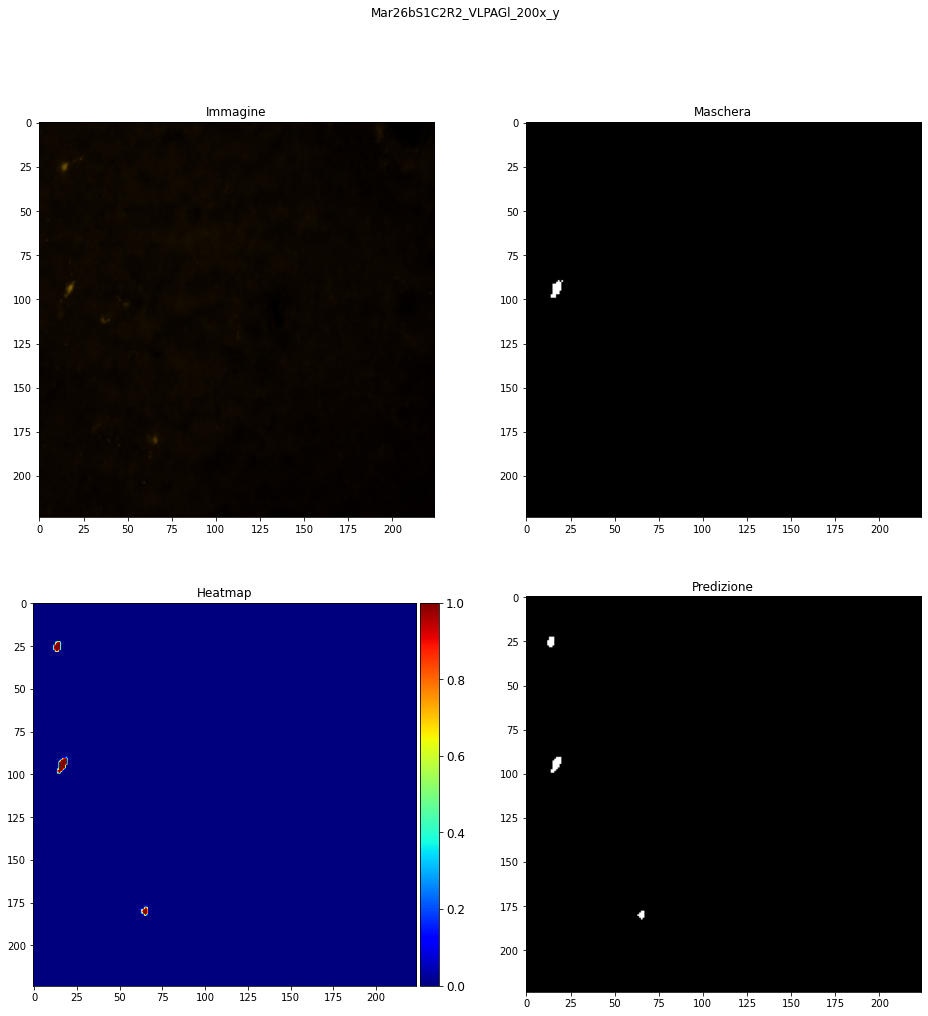

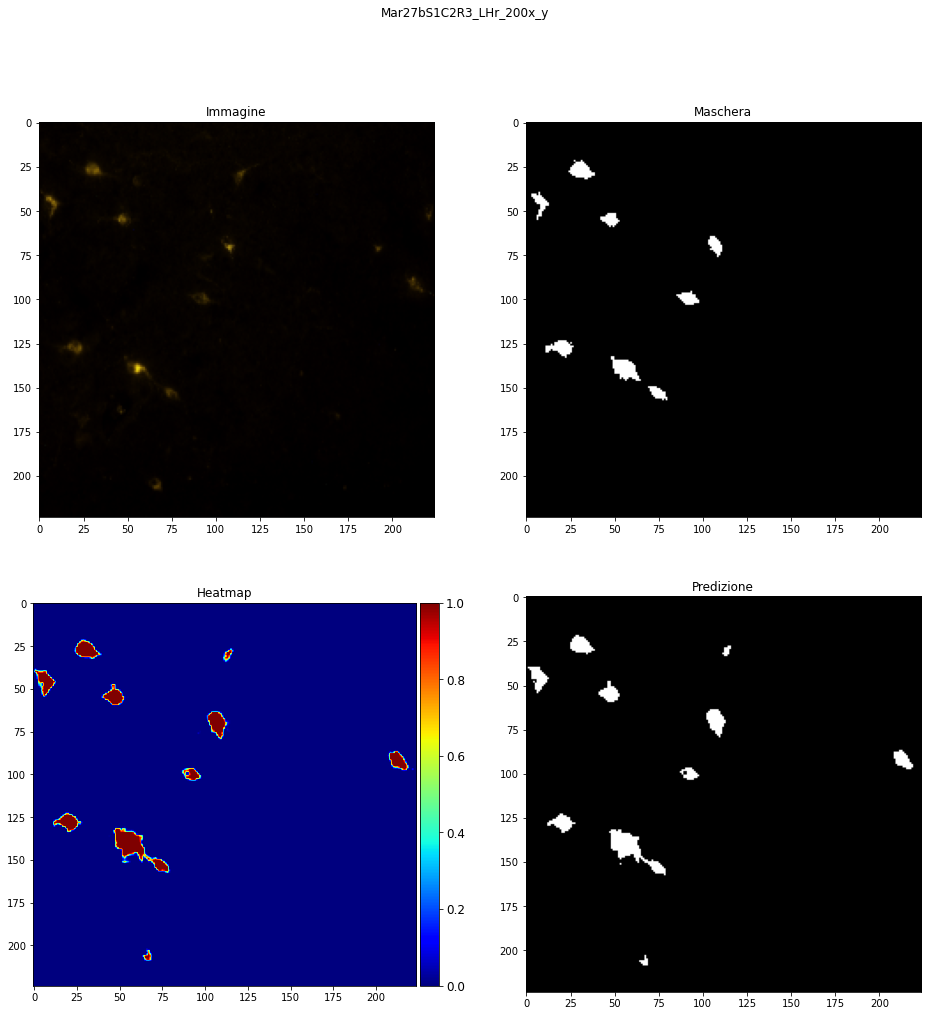

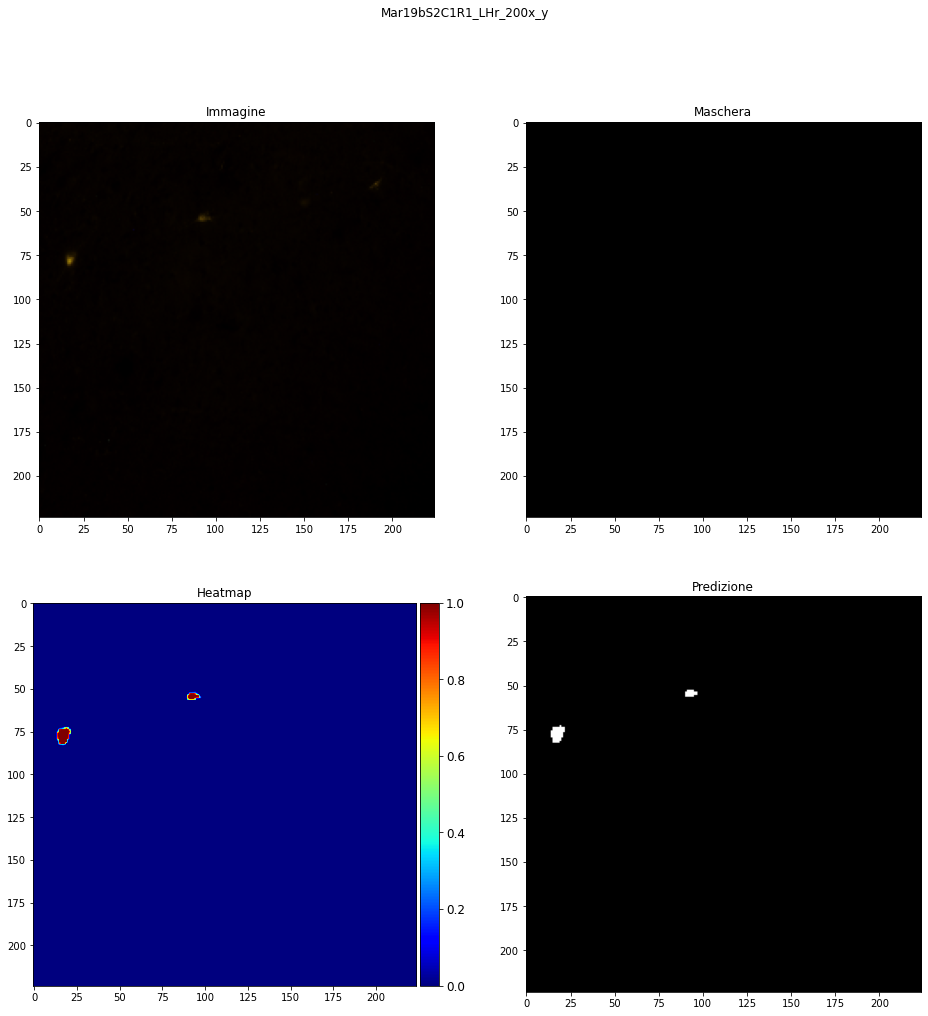

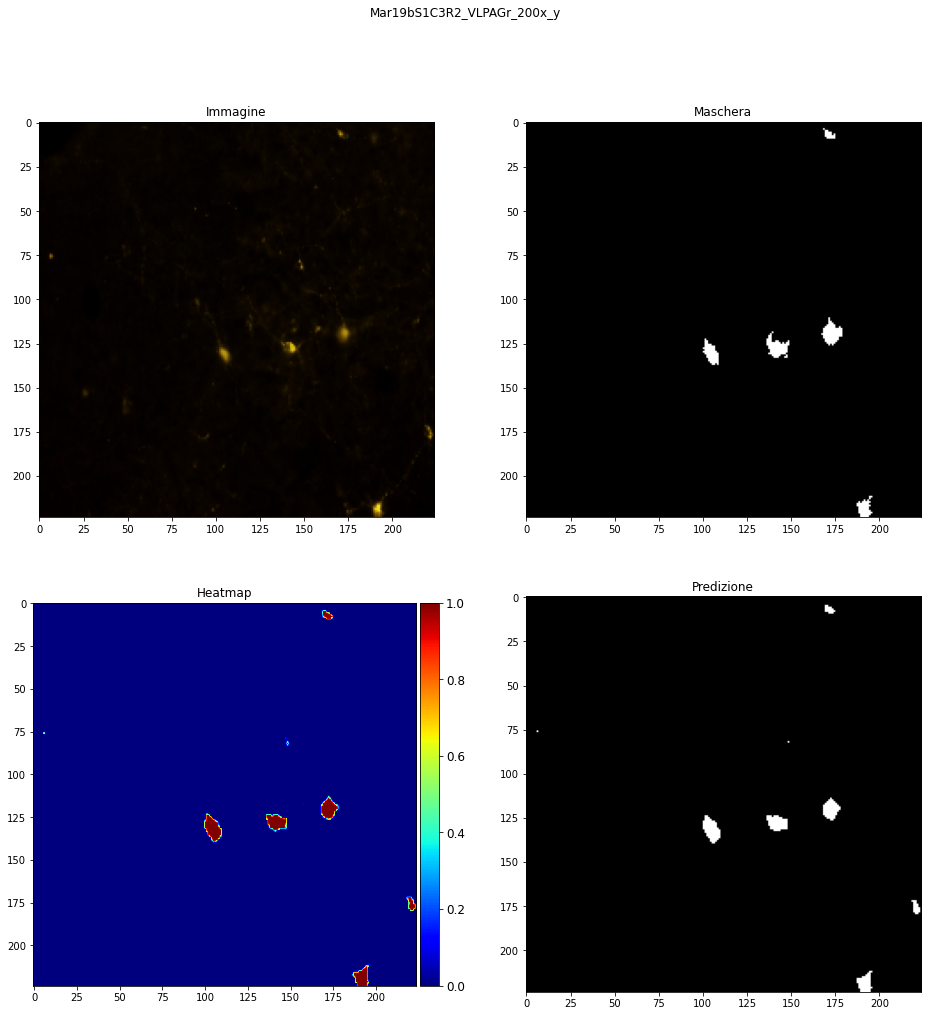

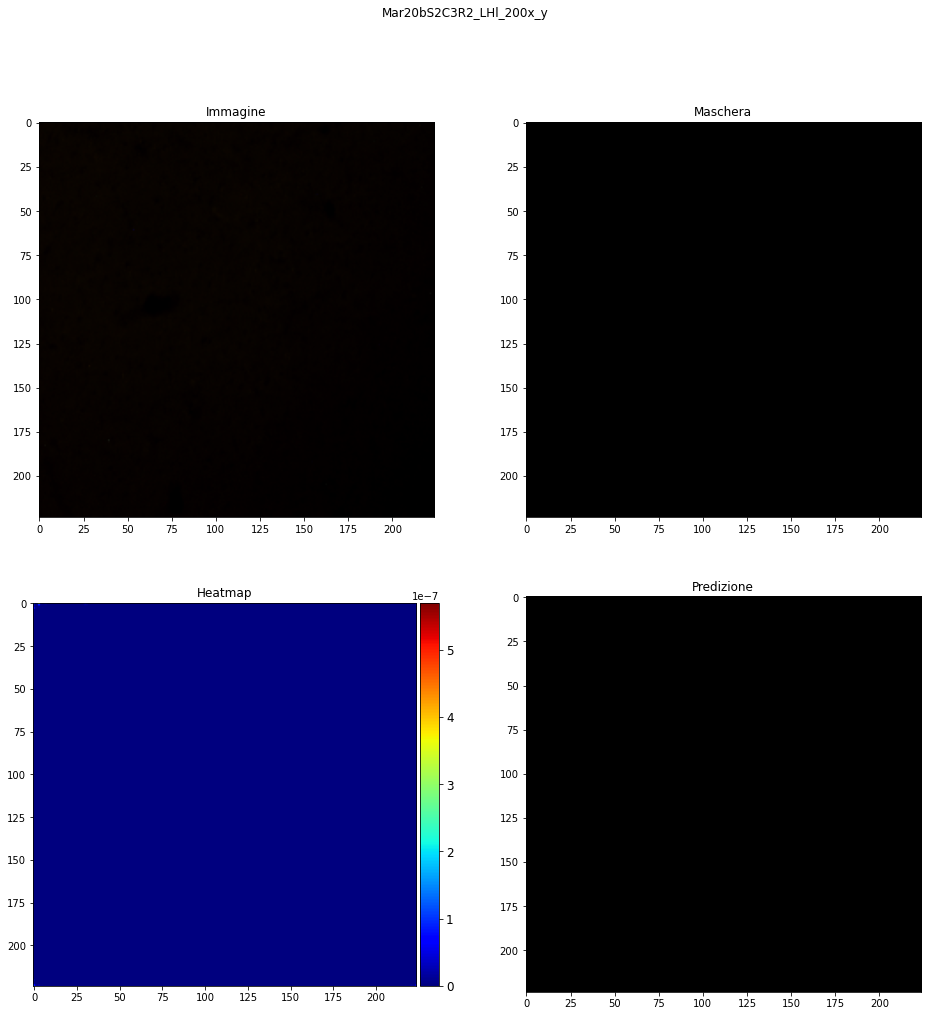

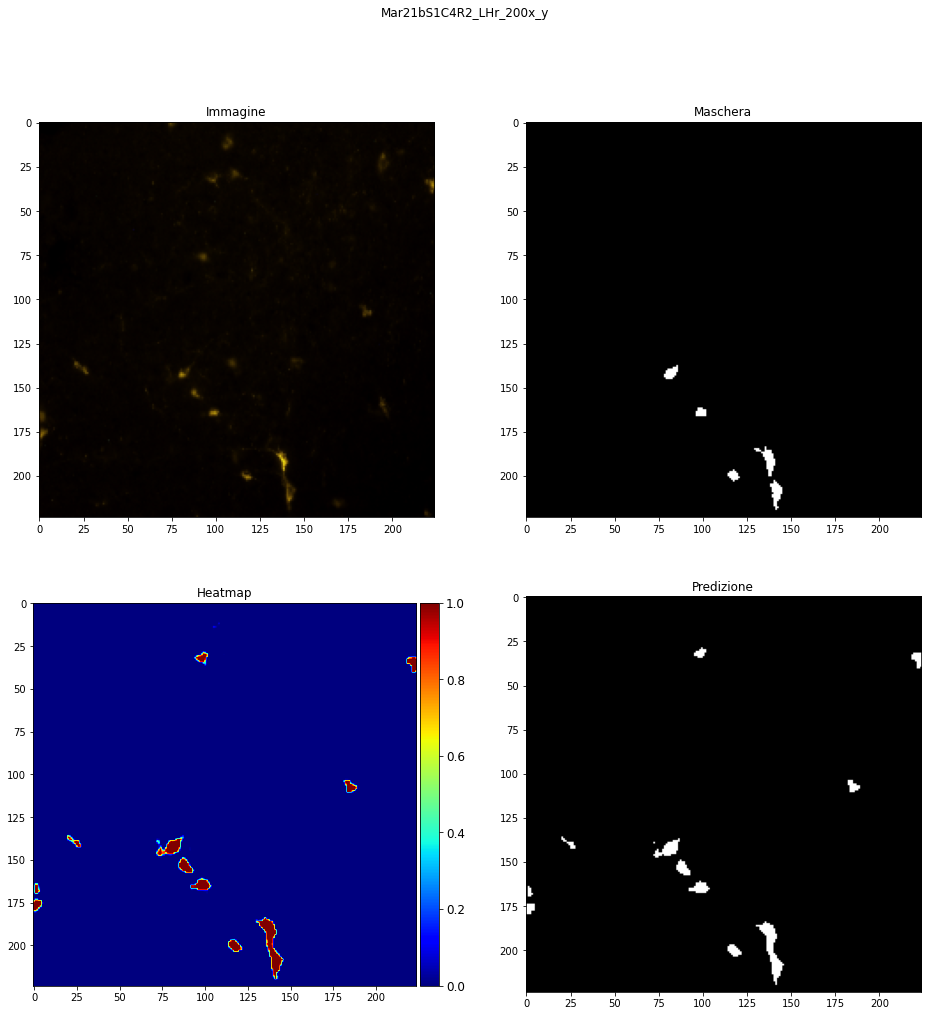

In [13]:
from tqdm.auto import tqdm

max_display=10
for idx, b in tqdm(enumerate(test_dl), total=min(max_display, test_dl.n)):
    img_name = test_dl.items[idx]
    img, mask, heatmap, pred_mask = make_prediction(b)
    
    # plot
    show_predict(img, mask, heatmap, pred_mask, img_name=img_name.stem)
    if idx>max_display:
        break

# Extra

## Thresholding $\neq0.5$

<div class="alert alert-block alert-info">

In alcune applicazioni è preferibile fissare una soglia di thresholding diversa da 0.5, ad esempio una soglia più alta in modo da considerare come cellule solo i pixel per cui il modello è molto confidente nella classificazione. 
    
In casi simili basterà semplicemente applicare la funzione di seguito per formattare l'heatmap in modo che `argmax` equivalga al thresholding desiderato:
    
    def thresh_format(pred, t=0.5):
        tr = torch.zeros_like(pred)
        tr[:, 0, :, :] = tr[:, 0, :, :].add(t-0.5)
        tr[:, 1, :, :] = tr[:, 1, :, :].add(0.5-t)
        return pred + tr
    
</div>

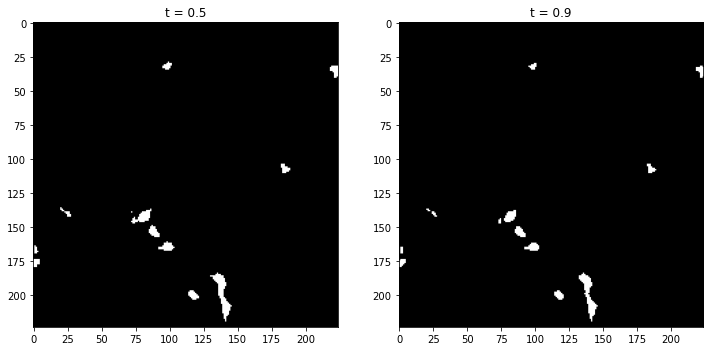

In [14]:
def thresh_format(pred, t=0.5):
    tr = torch.zeros_like(pred)
    tr[:, 0, :, :] = tr[:, 0, :, :].add(t-0.5)
    tr[:, 1, :, :] = tr[:, 1, :, :].add(0.5-t)
    return pred + tr

# threshold
t = 0.9

img, mask = b
with torch.no_grad():
    heatmap = learn.model(img)
    
pred_mask_t05 = heatmap.squeeze().permute(1,2,0).argmax(dim=2).squeeze().type(torch.uint8)
pred_mask_t = thresh_format(heatmap, t).squeeze().permute(1,2,0).argmax(dim=2).squeeze().type(torch.uint8)

fig, axes = plt.subplots(1,2, figsize=(12,6))
axes[0].imshow(pred_mask_t05, cmap='gray')
axes[0].set_title('t = 0.5')
axes[1].imshow(pred_mask_t, cmap='gray')
_ = axes[1].set_title(f't = {t}')

## Post-processing

Per migliorare la previsione del modello è possibile ripulire l'output grezzo attraverso:

 - rimozione buchi
 - rimozione oggetti piccoli
 - separazione oggetti vicini (*watershed*)
 
Di seguito è riportato un confronto dei risultati grezzi e dopo il post-processing.

  0%|          | 0/10 [00:00<?, ?it/s]

<ipython-input-16-bcaf60052728>:13: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  processed = remove_small_holes(labels_pred, area_threshold=area_threshold, connectivity=1,
<ipython-input-16-bcaf60052728>:26: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(maxi, indices=False, footprint=np.ones((foot, foot)),


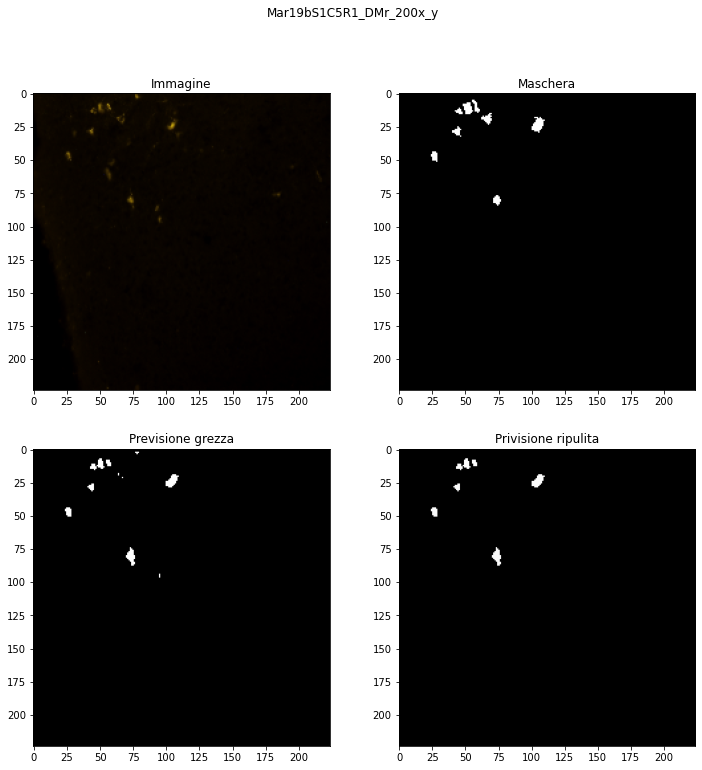

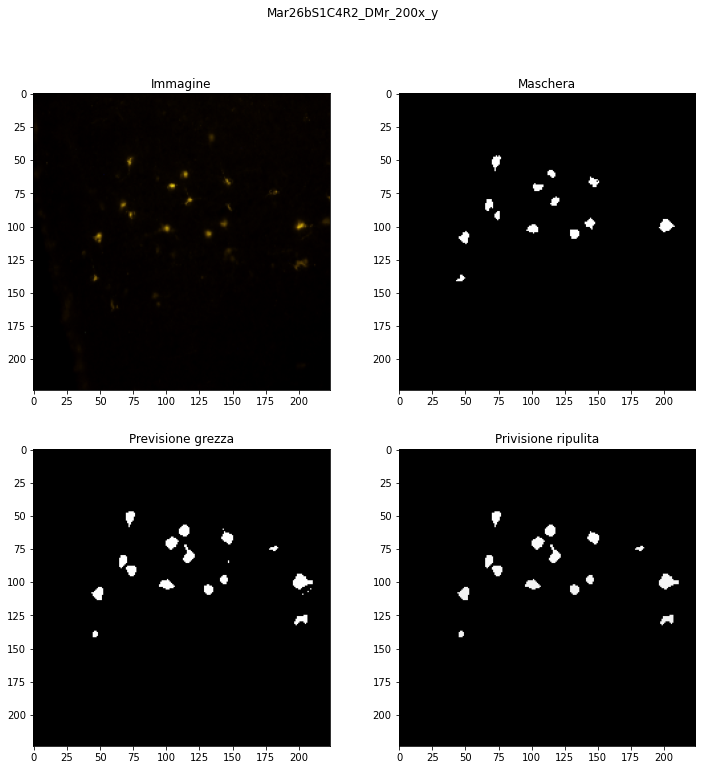

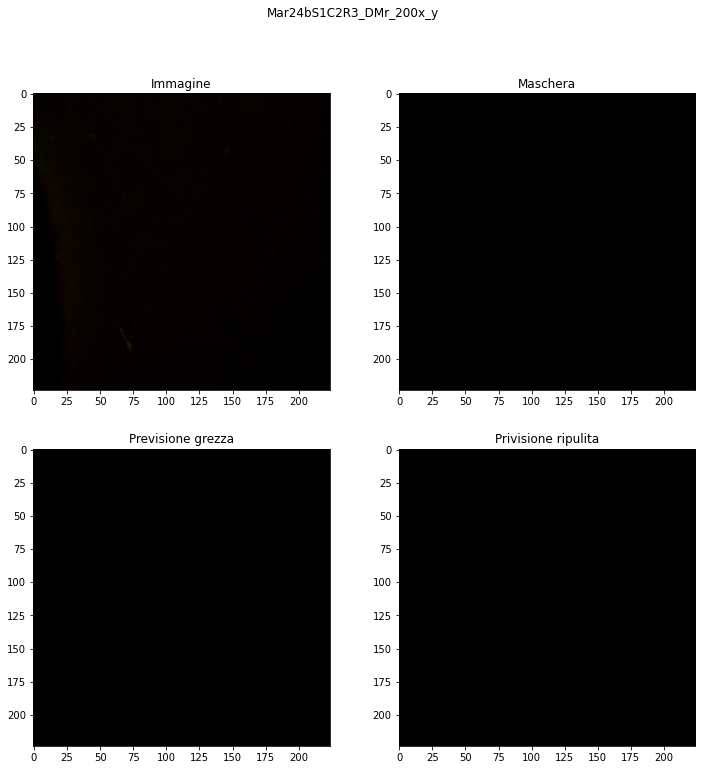

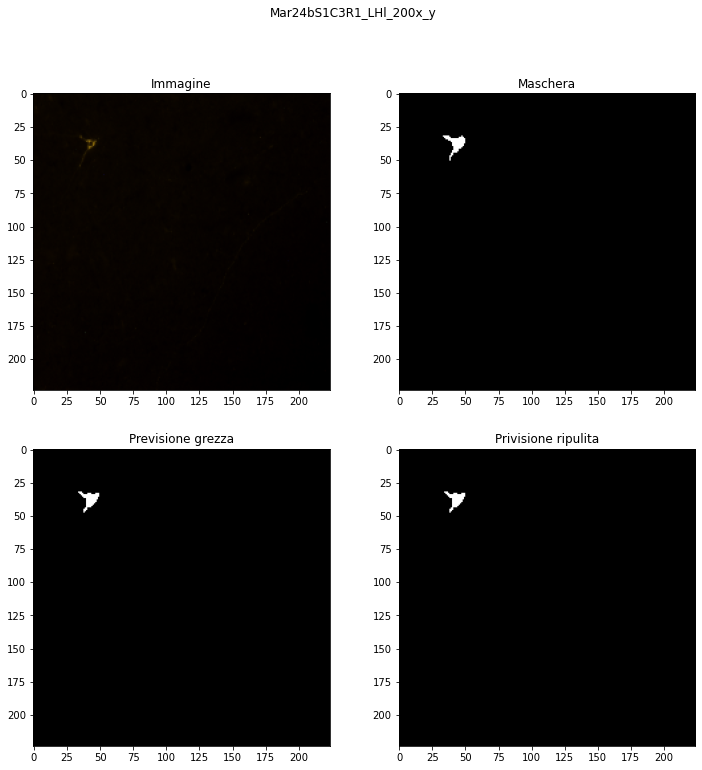

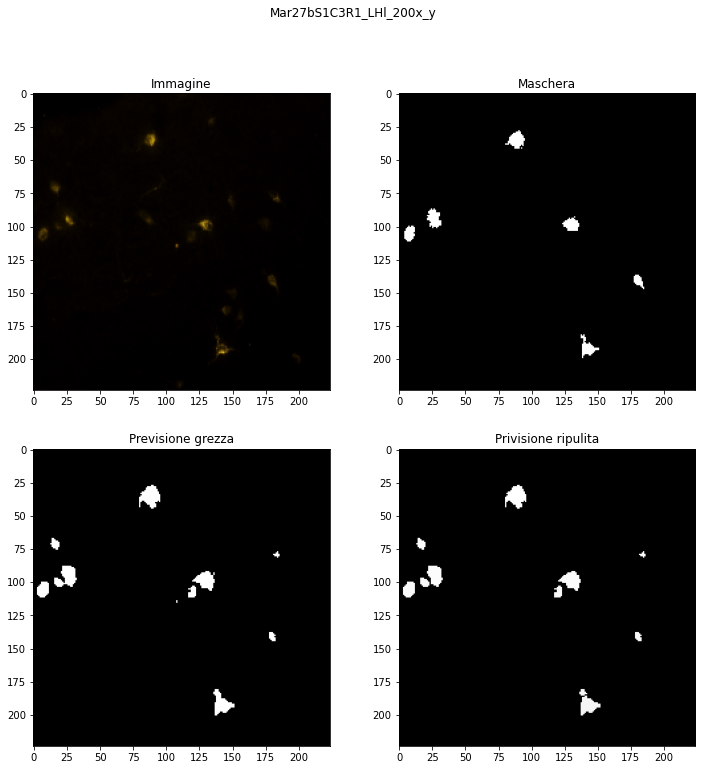

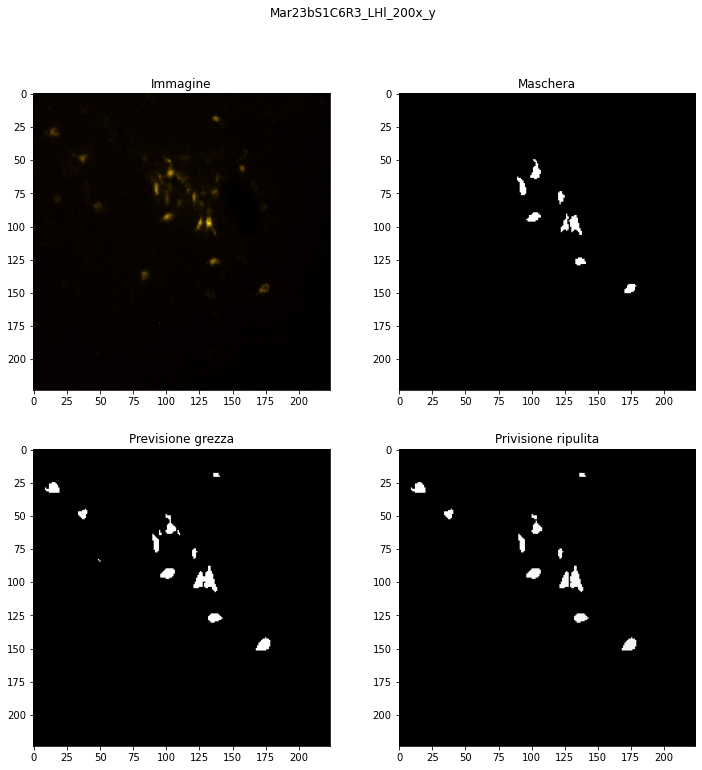

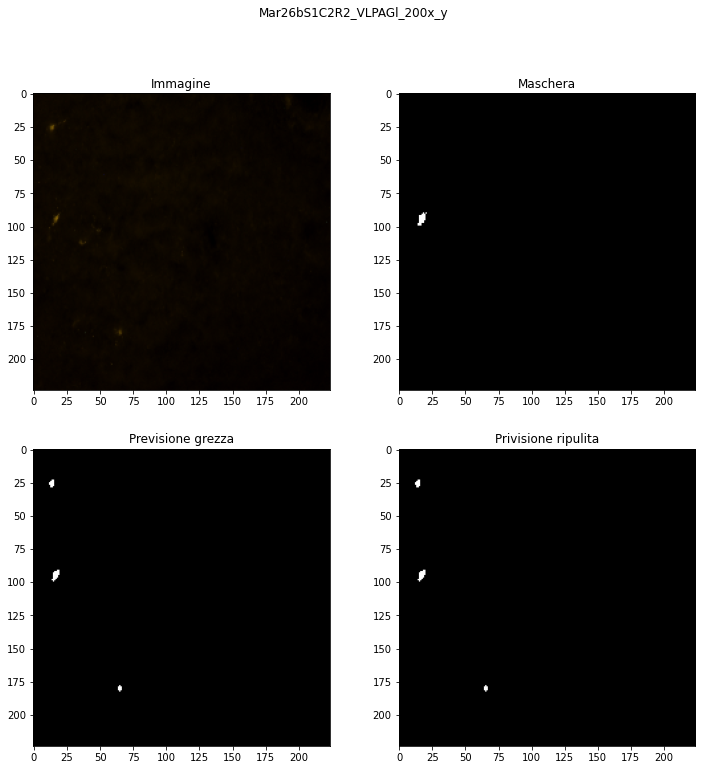

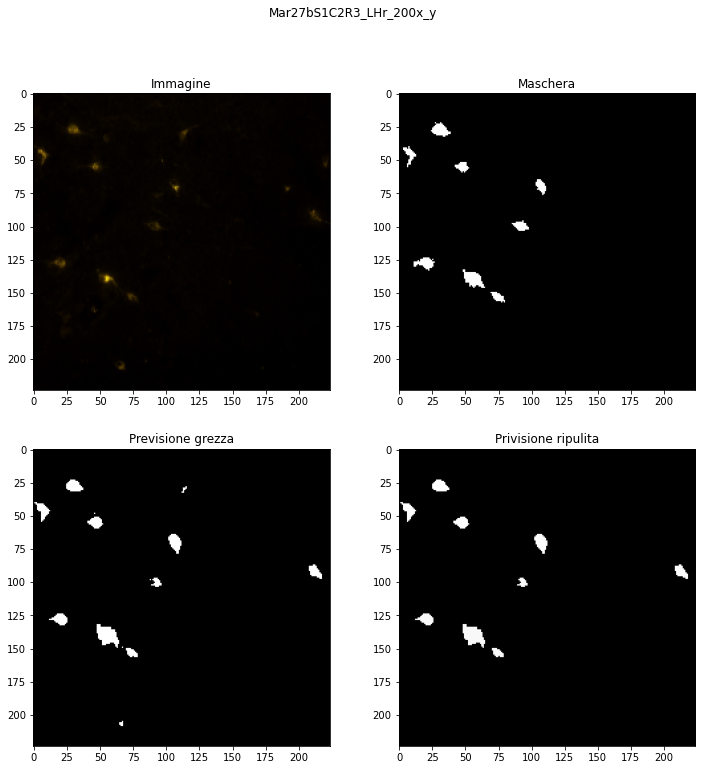

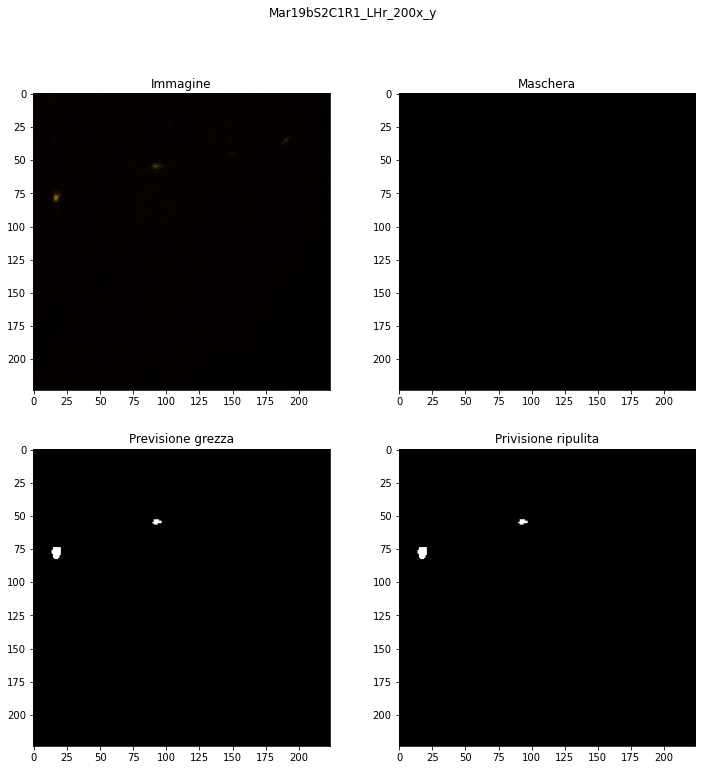

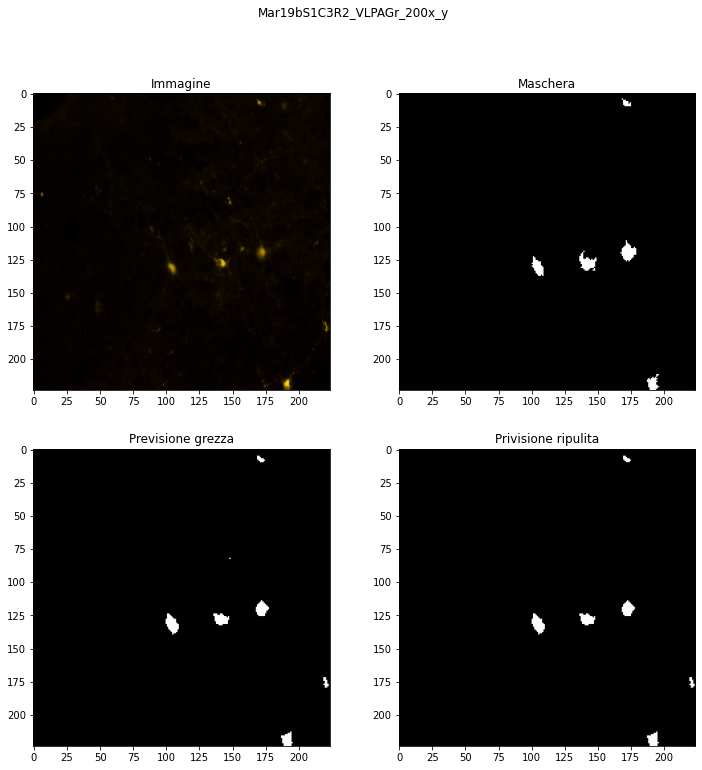

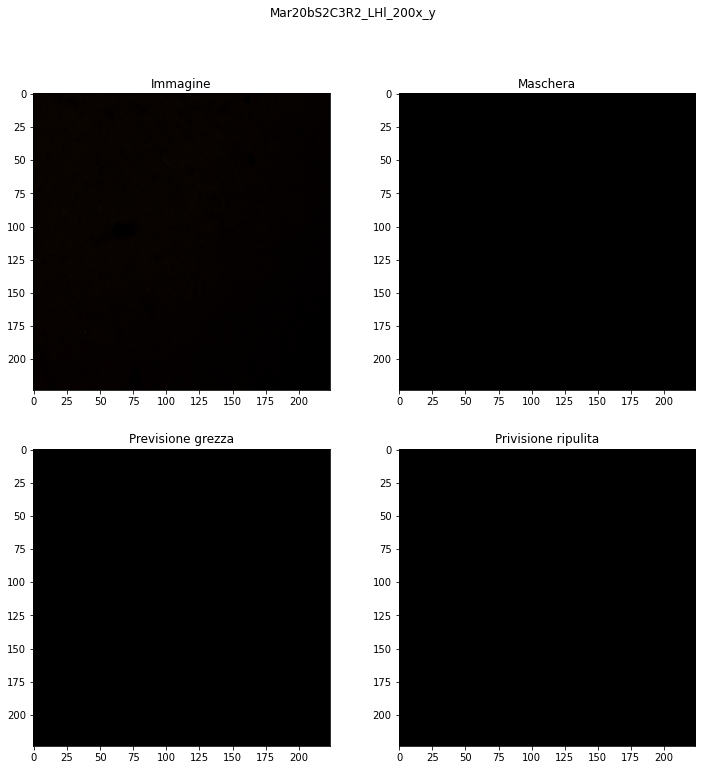

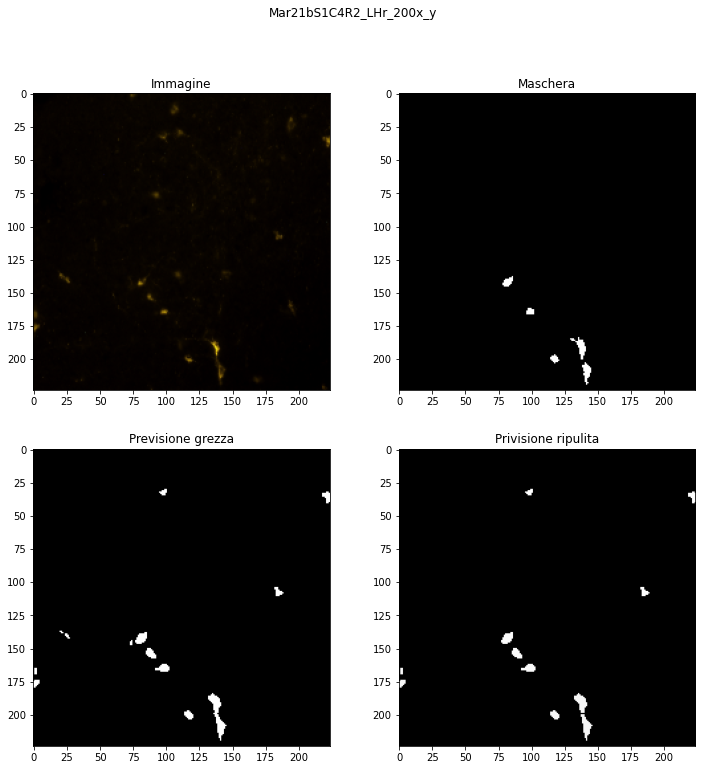

In [16]:
from skimage.feature import peak_local_max
from skimage.morphology import remove_small_holes, remove_small_objects, label
from skimage.segmentation import watershed
from scipy import ndimage
from math import hypot

def mask_post_processing(thresh_image, area_threshold=50, min_obj_size=10, max_dist=8, foot=8):

    # Find object in predicted image
    labels_pred, nlabels_pred = ndimage.label(thresh_image)
    
    # remove holes
    processed = remove_small_holes(labels_pred, area_threshold=area_threshold, connectivity=1,
                                   in_place=False)
    
    # remove small objects
    processed = remove_small_objects(
        processed, min_size=min_obj_size, connectivity=1, in_place=False)
    labels_bool = processed.astype(bool)

    
    # watershed
    distance = ndimage.distance_transform_edt(processed)

    maxi = ndimage.maximum_filter(distance, size=max_dist, mode='constant')
    local_maxi = peak_local_max(maxi, indices=False, footprint=np.ones((foot, foot)),
                                exclude_border=False,
                                labels=labels_bool)

    local_maxi = remove_small_objects(
        local_maxi, min_size=5, connectivity=1, in_place=False)
    markers = ndimage.label(local_maxi)[0]
    labels = watershed(-distance, markers, mask=labels_bool,
                       compactness=1, watershed_line=True)

    return(labels.astype("uint8")*255)


max_display=10
for idx, b in tqdm(enumerate(test_dl), total=min(max_display, test_dl.n)):
    img_name = test_dl.items[idx]
    img, mask = b
    with torch.no_grad():
        heatmap = learn.model(img)

    pred_mask_t = thresh_format(heatmap, t).squeeze().permute(1,2,0).argmax(dim=2).squeeze().type(torch.uint8) # .to('cpu')
    pred_mask_cleaned = mask_post_processing(pred_mask_t)

    fig, axes = plt.subplots(2, 2, figsize=(12,12))
    fig.suptitle(img_name.stem)
    axes = axes.flatten()

    axes[0].imshow(img.squeeze().permute(1,2,0))
    axes[0].set_title('Immagine')
    axes[1].imshow(mask.squeeze(), cmap='gray')
    axes[1].set_title('Maschera')
    axes[2].imshow(pred_mask_t, cmap='gray')
    _ = axes[2].set_title('Previsione grezza')

    axes[3].imshow(pred_mask_cleaned, cmap='gray')
    _ = axes[3].set_title('Privisione ripulita')
    plt.show()
    if idx>max_display:
        break